In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxpy as cp
from tqdm.auto import tqdm
import statsmodels.api as sm
import warnings
from scipy.linalg import sqrtm

plt.style.use('ggplot')
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
start_date = '1995-01-01'
precios_indice = yf.download("SPY", start=start_date)[["Adj Close"]] # Precios ajustados al cierre

[*********************100%%**********************]  1 of 1 completed


In [3]:
filepath = 'https://raw.githubusercontent.com/alfonso-santos/microcredencial-carteras-python-2023/main/Tema_5_APT/data/sp500_tickers.csv'
tickers_sp500 = list(pd.read_csv(filepath))

precios = yf.download(tickers_sp500, start=start_date)['Adj Close']

precios_activos_sp500_tmp = precios.copy()
precios_activos_sp500_tmp.dropna(axis=1, inplace=True)
#ret_activos_sp500 = np.log(precios_activos_sp500).diff().dropna()

[                       1%%                      ]  4 of 503 completed

[*********************100%%**********************]  503 of 503 completed

3 Failed downloads:
['BRK.B', 'CDAY']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1995-01-01 -> 2024-04-14)')


In [6]:
num_act_max = 50

num_columnas = precios_activos_sp500_tmp.shape[1]

# Generar índices aleatorios para seleccionar num_act_max activos sin repetición

# Fijar la semilla del generador de números aleatorios
np.random.seed(42)  # Puedes usar cualquier número entero como semilla

indices_aleatorios = np.random.choice(num_columnas, size=50, replace=False)

# Seleccionar las columnas del array original usando los índices aleatorios
precios_activos_sp500 = precios_activos_sp500_tmp.iloc[:, indices_aleatorios]



In [4]:
#ret_activos_sp500 = np.log(precios_activos_sp500).diff().dropna()

In [7]:
# Agrupar por año y mes y obtener las fechas del primer y último día de cada mes presentes en el índice

fechas_primer_dia = precios_activos_sp500.groupby([precios_activos_sp500.index.year, precios_activos_sp500.index.month]).apply(lambda x: x.index.min())
fechas_ultimo_dia = precios_activos_sp500.groupby([precios_activos_sp500.index.year, precios_activos_sp500.index.month]).apply(lambda x: x.index.max())

In [8]:
precios_activos_mes_ini = precios_activos_sp500.loc[fechas_primer_dia]

precios_activos_mes_fin = precios_activos_sp500.loc[fechas_ultimo_dia]

ret_activos_mes_ini = np.log(precios_activos_mes_ini).diff().dropna()

ret_activos_mes_fin = np.log(precios_activos_mes_fin).diff().dropna()


In [9]:
len(fechas_primer_dia), len(fechas_ultimo_dia), len(precios_activos_mes_ini), len(precios_activos_mes_fin)

(352, 352, 352, 352)

# Comprobar que las fechas son las correctas

In [10]:
rebalan_per  = 3 # Periodo de rebalanceo 3 meses
calculo_cartera_per = 60 # Periodo de datos para calcular las carteras 5 años
calculo_inicio_per = 120 # Periodo de datos para calcular la primera cartera para que empiece 31-12

if calculo_cartera_per >= calculo_inicio_per:
    raise ValueError('El periodo de cálculo de la cartera debe ser menor al periodo de inicio de cálculo')

rebalan_fechas = fechas_primer_dia.iloc[calculo_inicio_per::rebalan_per].values
rebalan_fechas_final = fechas_ultimo_dia.iloc[calculo_inicio_per+rebalan_per-1::rebalan_per].values

# Por si no hay fecha final para el último periodo de rebalanceo
if (len(rebalan_fechas) > len(rebalan_fechas_final)):
    rebalan_fechas = rebalan_fechas[:-1]


# Calcular la fecha que es 60 meses anterior para cada fecha en el índice
inicio_calc_fechas = pd.Series(rebalan_fechas) - pd.DateOffset(months=calculo_cartera_per)

# Asguro que , para el cáculo de la primera careta, la fecha de inicio sea la primera fecha del índice de los precios mensuales
inicio_calc_fechas[0] = precios_activos_mes_ini.index[0]

In [11]:
precios_rebalan = precios_activos_sp500.loc[rebalan_fechas]
precios_rebalan_final = precios_activos_sp500.loc[rebalan_fechas_final]

In [12]:
def cartera_min_vol (ret):
    
    if isinstance(ret, pd.DataFrame):
    
        num_act = ret.shape[1]
        matriz_cov = ret.cov().to_numpy()
        
            #Variables de decisión
        pesos = cp.Variable(num_act)
        
        #Restricciones
        constraints = [pesos >= 0,
                    cp.sum(pesos) == 1,
                    ]
        
        riesgo = cp.quad_form(pesos, matriz_cov) # Riesgo de la cartera
        objective = cp.Minimize(riesgo) # Minimizar la varianza

        #Problema y resuelvo
        prob = cp.Problem(objective, constraints)
        resultado = prob.solve()

        pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos.value])

        return pesos_ajustados
    
    else:
        raise ValueError('La función cartera_min_vol solo acepta un DataFrame como argumento')

In [13]:
def cartera_max_sharpe(ret, ret_rf):
    
    num_act = ret.shape[1]
    matriz_cov = ret.cov().to_numpy()
    retornos_esperados = ret.mean()

    # Variable de decisión (pesos del portafolio)
    x = cp.Variable(num_act)
    # Riesgo (desviación estándar) del portafolio
    riesgo = cp.quad_form(x, matriz_cov)

    #Cálculo de pi como retornos esperados menos la rantabilidad del activo libre de riesgo
    pi = np.array(retornos_esperados - ret_rf)

    #Restricciones
    constraints = [pi @ x ==1, # para que el numerador sea 1
                x>=0]       # sin posiciones cortas

    objective = cp.Minimize(riesgo) # Minimizo el riesgo

    # Problema de optimización
    problema = cp.Problem(objective, constraints)        

    # Resolver el problema
    resultado  = problema.solve(solver=cp.ECOS)

    # Normalizo los pesos
    pesos = x.value
    pesos /= pesos.sum()

    pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos])

    return pesos_ajustados

In [25]:
def cartera_risk_parity (ret):
    
    num_act = ret.shape[1]
    matriz_cov = ret.cov().to_numpy()
    retornos_esperados = ret.mean().to_numpy()
    
    b = 1/num_act

    x = cp.Variable((num_act,1))
    gamma = cp.Variable((num_act,1), nonneg=True)
    psi = cp.Variable(nonneg=True)

    z = matriz_cov @ x

    obj = cp.pnorm(b**0.5 * psi - gamma, p=2)
    ret = retornos_esperados.T @ x

    constraints = [cp.sum(x) == 1,
                x >= 0,
                cp.SOC(psi, sqrtm(matriz_cov) @ x),
                # ret >= 0.0006,
                ]

    for i in range(num_act):
        constraints += [cp.SOC(x[i,0] + z[i,0],
                            cp.vstack([2*gamma[i:i+1], x[i:i+1] - z[i:i+1]]))
                        ]

    objective = cp.Minimize(obj * 1000)
    prob = cp.Problem(objective, constraints)
    #prob.solve(solver=cp.SCS, verbose = False, eps=1e-5)
    prob.solve()
    
    pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in x.value])

    return pesos_ajustados

In [15]:
# Calculo los pesos de la cartera de mínima volatilidad

# Uso los retornos del final del periodo de cálculo para calcular los pesos de la cartera de mínima volatilidad

min_vol_list = []
for i in range(len(rebalan_fechas)):
    pesos_tmp = cartera_min_vol(ret_activos_mes_fin.loc[inicio_calc_fechas[i]: rebalan_fechas[i]])
    min_vol_list.append(pesos_tmp)
    

pesos_ini_min_vol = pd.DataFrame(min_vol_list, columns=ret_activos_mes_fin.columns, index=rebalan_fechas)

In [16]:
# Cáculo de los pesos al final del periodo de rebalanceo

dinero_final_min_vol = (np.array(precios_rebalan_final) * pesos_ini_min_vol)

suma_dinero_min_vol = dinero_final_min_vol.sum(axis=1)

pesos_final_min_vol = dinero_final_min_vol.div(suma_dinero_min_vol, axis=0)

dif_pesos_min_vol = np.abs((pesos_final_min_vol - pesos_ini_min_vol.shift(-1))).dropna()

In [17]:
# Calculo los pesos de la cartera de max sharpe

# Uso los retornos del final del periodo de cálculo para calcular los pesos de la cartera de mínima volatilidad
ret_rf = 0.01/252 # Tasa libre de riesgo
max_sharpe_list = []
for i in range(len(rebalan_fechas)):
    pesos_tmp = cartera_max_sharpe(ret_activos_mes_fin.loc[inicio_calc_fechas[i]: rebalan_fechas[i]], ret_rf)
    max_sharpe_list.append(pesos_tmp)
    

pesos_ini_max_sharpe = pd.DataFrame(max_sharpe_list, columns=ret_activos_mes_fin.columns, index=rebalan_fechas)

In [18]:
# Cáculo de los pesos al final del periodo de rebalanceo

dinero_final_max_sharpe = (np.array(precios_rebalan_final) * pesos_ini_max_sharpe)

suma_dinero_max_sharpe = dinero_final_max_sharpe.sum(axis=1)

pesos_final_max_sharpe = dinero_final_max_sharpe.div(suma_dinero_max_sharpe, axis=0)

dif_pesos_max_sharpe = np.abs((pesos_final_max_sharpe - pesos_ini_max_sharpe.shift(-1))).dropna()

In [28]:
# Calculo los pesos de la cartera risk parity

# Uso los retornos del final del periodo de cálculo para calcular los pesos de la cartera de mínima volatilidad

risk_parity_list = []
for i in range(len(rebalan_fechas)):
    pesos_tmp = cartera_risk_parity(ret_activos_mes_fin.loc[inicio_calc_fechas[i]: rebalan_fechas[i]])
    risk_parity_list.append(pesos_tmp)
    
risk_parity_flat = [item[:, 0] for item in risk_parity_list]

pesos_ini_risk_parity = pd.DataFrame(risk_parity_flat, columns=ret_activos_mes_fin.columns, index=rebalan_fechas)

In [29]:
# Cáculo de los pesos al final del periodo de rebalanceo

dinero_final_risk_parity = (np.array(precios_rebalan_final) * pesos_ini_risk_parity)

suma_dinero_risk_parity = dinero_final_risk_parity.sum(axis=1)

pesos_final_risk_parity = dinero_final_risk_parity.div(suma_dinero_risk_parity, axis=0)

dif_pesos_risk_parity = np.abs((pesos_final_risk_parity - pesos_ini_risk_parity.shift(-1))).dropna()

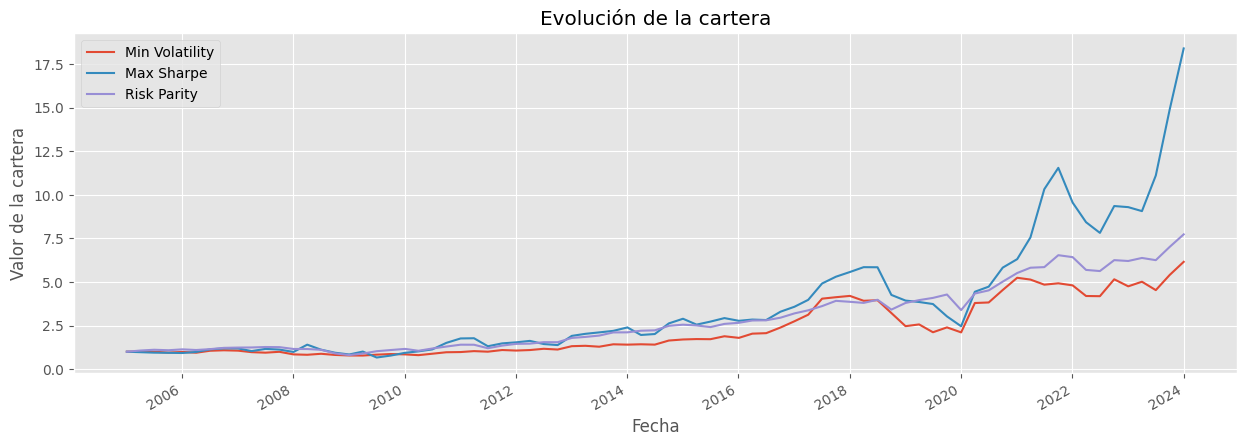

In [53]:
# Evolución de la cartera sin tener en cuenta los costes

# Configurar el tamaño de la figura
plt.figure(figsize=(15, 5))  # Tamaño en pulgadas (ancho, alto)

# Generar las gráficas
(suma_dinero_min_vol/suma_dinero_min_vol[0]).plot(label='Min Volatility')
(suma_dinero_max_sharpe/suma_dinero_max_sharpe[0]).plot(label='Max Sharpe')
(suma_dinero_risk_parity/suma_dinero_risk_parity[0]).plot(label='Risk Parity')

# Añadir título y etiquetas a los ejes
plt.title('Evolución de la cartera')
plt.xlabel('Fecha')
plt.ylabel('Valor de la cartera')

# Añadir una leyenda
plt.legend()

plt.show()

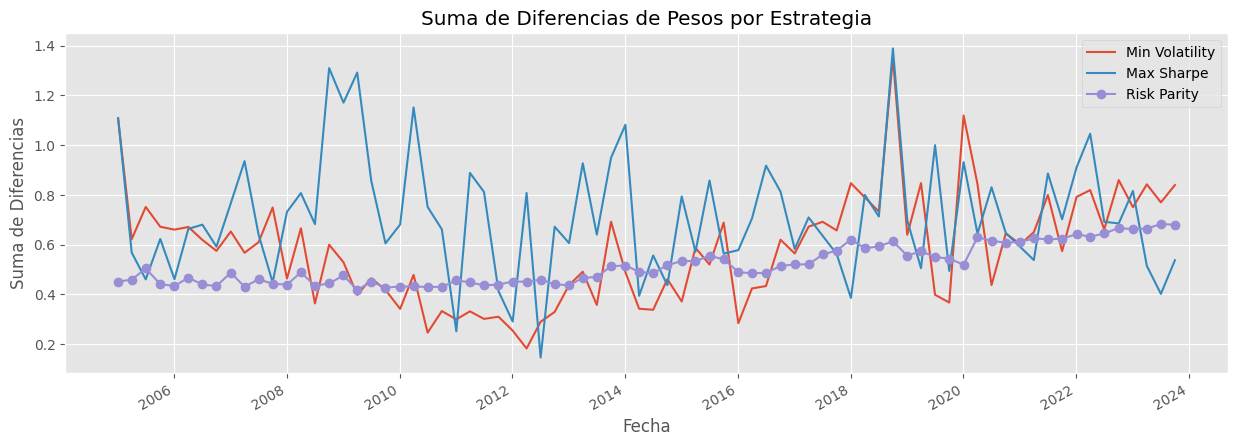

In [33]:
# Configurar el tamaño de la figura
plt.figure(figsize=(15, 5))  # Tamaño en pulgadas (ancho, alto)

# Generar las gráficas
dif_pesos_min_vol.sum(axis=1).plot(label='Min Volatility')
dif_pesos_max_sharpe.sum(axis=1).plot(label='Max Sharpe')
dif_pesos_risk_parity.sum(axis=1).plot(label='Risk Parity', marker='o')

# Añadir título y etiquetas
plt.title('Suma de Diferencias de Pesos por Estrategia')
plt.xlabel('Fecha')  # Asumiendo que el índice es de tipo fecha
plt.ylabel('Suma de Diferencias')

# Añadir leyenda
plt.legend()

# Mostrar la gráfica
plt.show()


In [35]:
dif_pesos_min_vol.sum().sum(), dif_pesos_max_sharpe.sum().sum(), dif_pesos_risk_parity.sum().sum()

(43.91720943816975, 54.128410780761165, 39.274679699832724)

In [50]:
np.abs(pesos_ini_min_vol.diff()).sum(axis=1).sum(), np.abs(pesos_ini_max_sharpe.diff()).sum(axis=1).sum(), np.abs(pesos_ini_risk_parity.diff()).sum(axis=1).sum()

(24.973, 41.199999999999996, 4.892)

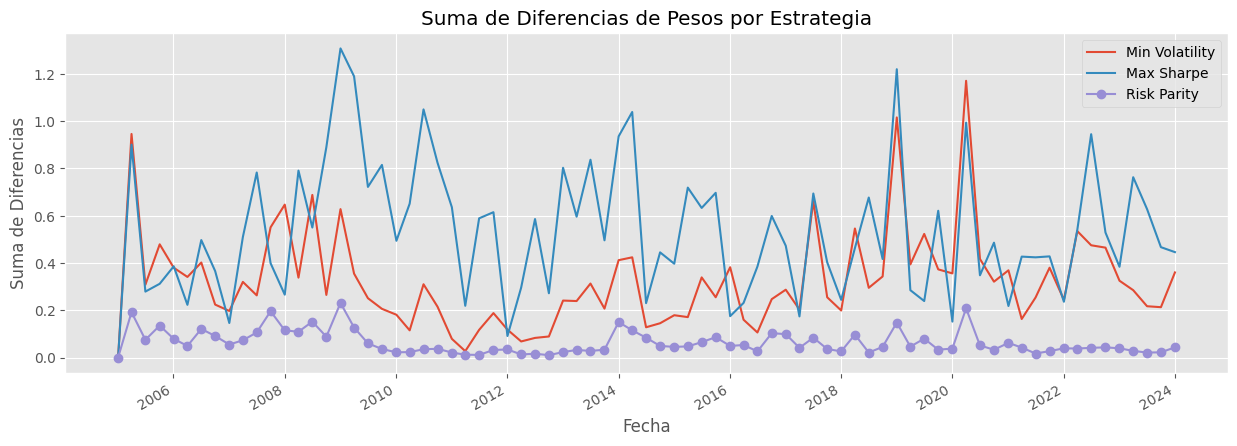

In [40]:
# Configurar el tamaño de la figura
plt.figure(figsize=(15, 5))  # Tamaño en pulgadas (ancho, alto)

# Generar las gráficas
np.abs(pesos_ini_min_vol.diff()).sum(axis=1).plot(label='Min Volatility')
np.abs(pesos_ini_max_sharpe.diff()).sum(axis=1).plot(label='Max Sharpe')
np.abs(pesos_ini_risk_parity.diff()).sum(axis=1).plot(label='Risk Parity', marker='o')

# Añadir título y etiquetas
plt.title('Suma de Diferencias de Pesos por Estrategia')
plt.xlabel('Fecha')  # Asumiendo que el índice es de tipo fecha
plt.ylabel('Suma de Diferencias')

# Añadir leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

In [ ]:
precios_activos_sp500.loc['2020':'2023']/precios_activos_sp500.loc['2020':'2023'].iloc[0]

<Figure size 640x480 with 0 Axes>

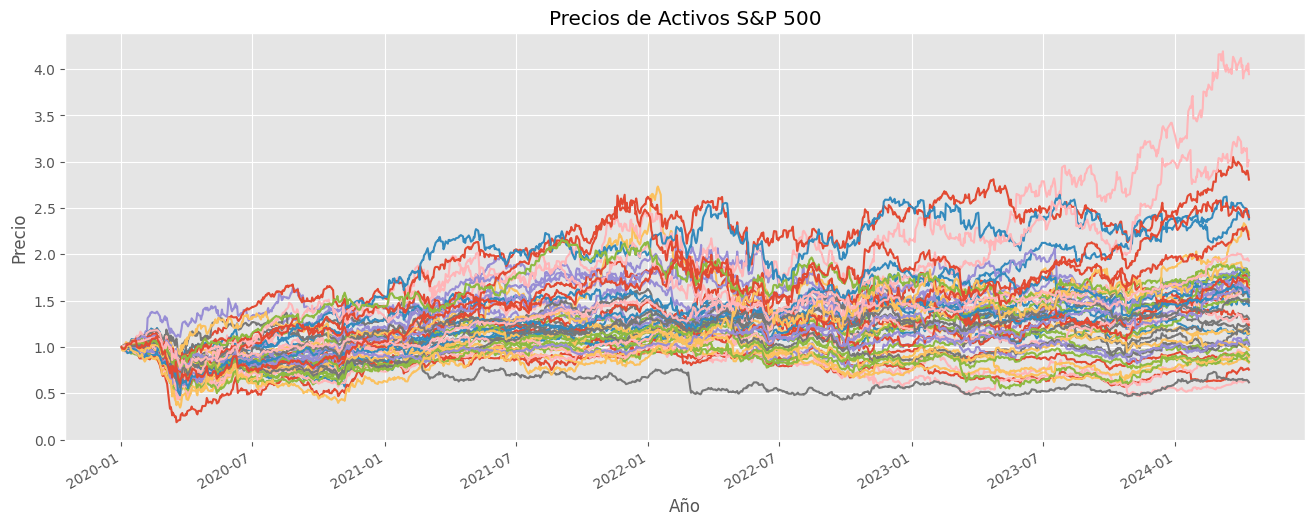

In [58]:
# Configurar el tamaño de la figura
plt.figure()  # Tamaño en pulgadas (ancho por alto)

inicio ='2020'
fin = '2024'

# Ploteo de los datos seleccionados entre 2010 y 2013
(precios_activos_sp500.loc[inicio:fin]/precios_activos_sp500.loc[inicio:fin].iloc[0]).plot(legend=None, figsize=(16, 6))

# Añadir título y etiquetas de los ejes para claridad
plt.title('Precios de Activos S&P 500')
plt.xlabel('Año')
plt.ylabel('Precio')

# Mostrar la gráfica
plt.show()


In [73]:
precios_rebalan.iloc[:-1,:].tail(2)

Ticker,MMM,REG,GEN,SO,CNP,AFL,HAS,PPL,TRV,BBY,...,EQR,DHI,INTU,GPC,AEP,STZ,VLO,DHR,WM,RJF
Date,,,,,,,,,,,,,,,,,,,,,
2023-07-03,79.942360,60.444717,18.116409,68.426117,28.828831,68.996696,62.199810,25.915527,170.297577,79.154305,...,64.367195,119.400749,448.702301,164.661499,82.542778,244.840424,114.690483,209.235016,169.323059,102.749527
2023-10-02,72.590294,56.842957,17.320436,61.435005,25.377552,75.596397,62.406925,22.129747,160.652405,67.411064,...,56.647003,105.714912,515.402100,143.199738,70.222733,246.808578,135.945343,213.024368,150.051163,97.353348


In [67]:
dif_pesos_min_vol.tail(2)

Ticker,MMM,REG,GEN,SO,CNP,AFL,HAS,PPL,TRV,BBY,...,EQR,DHI,INTU,GPC,AEP,STZ,VLO,DHR,WM,RJF
2023-07-03,0.0,0.0,0.0,0.001708,0.0,0.0,0.012701,0.0,0.054131,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009978,0.0
2023-10-02,0.0,0.0,0.0,0.000000,0.0,0.0,0.025616,0.0,0.068760,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057827,0.0


In [74]:
dif_pesos_min_vol.shape, precios_rebalan.iloc[:-1,:].shape

((76, 50), (76, 50))

In [75]:
dinero_rebalanceado_min_vol = (np.array(precios_rebalan.iloc[:-1,:]) * dif_pesos_min_vol)

In [83]:
dinero_final_min_vol.iloc[:-1,:].sum(axis=1)

2005-01-03     24.566721
2005-04-01     24.917805
2005-07-01     24.556460
2005-10-03     23.357716
2006-01-03     24.275560
                 ...    
2022-10-03    126.602901
2023-01-03    116.695119
2023-04-03    123.176102
2023-07-03    111.359602
2023-10-02    132.704073
Length: 76, dtype: float64

In [85]:
coste = 0.01
coste_balancear = dinero_rebalanceado_min_vol.sum(axis=1)*coste

In [86]:
coste_balancear/dinero_final_min_vol

,2005-01-03 00:00:00,2005-04-01 00:00:00,2005-07-01 00:00:00,2005-10-03 00:00:00,2006-01-03 00:00:00,2006-04-03 00:00:00,2006-07-03 00:00:00,2006-10-02 00:00:00,2007-01-03 00:00:00,2007-04-02 00:00:00,...,SYK,TRV,TSCO,TXN,USB,VLO,VRTX,VTRS,VZ,WM
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
